# <center>EE6770 Fall 2024 Homework 5: Cats and Dogs Classifier</center>

1. __Write comments__ in the code to explain your thoughts.
2. __Important: Execute the codes and show the results__. 
3. __Do your own work.__ 

### Submission:
 * __Submit this notebook file and the pdf version__ - remember to add your name in the filename.
 * Deadline: 11:59 pm, 10/28 (Monday)

## Assignment Objectives:

### In this assignment, you will develop a CNN model for the cat-and-dog classifer. 
#### You will create `at least two models`, applying the various techniques we discussed for improving the performance. 

1. Deeper Conv layers and/or FC layers
2. Image augmentation
3. Transfer learning
4. Regularization: L1/L2, Batch Normalization, Dropout, Max Norm
5. Increasing image size
6. Increasing size of the train/validation/test dataset

* You will compare the performance of your models with the baseline VGG-5 model that we discussed in class.
* <font color=red>Image size is limited to 128-by-128 or smaller </font>
* <font color=red>Performance requirement: the accuracy on the test data needs to be better than 87.5% for at least one of your models </font>

### Cats & Dogs Dataset

* #### You are given a zip file, `train.zip`, that contains 25,000 labelled images of cats and dogs (12,500 each) 
* #### You will select a subset of $N$ image files from the dataset and store them in the following sub-directory structure, where $N$ can be anywhere between 10,000 to 25,000.
* #### The train-validation-test data split is 60%-15%-25%.
<img src="./images/train_test_dir.png" alt="Drawing" style="width: 250px;"/> 

### Load tool modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

print(tf.config.list_physical_devices())

2024-10-25 14:29:11.268327: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-25 14:29:11.288797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 14:29:11.305299: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 14:29:11.310089: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-25 14:29:11.330801: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1729880953.481944  117620 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729880953.846863  117620 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729880953.846914  117620 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


### Load CNN models

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout

### Load the image processing tools 

In [3]:
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import image_dataset_from_directory

### Load and Process the dataset
__Create the subdirectory structures per the requirement.__

In [4]:
import os
import shutil

#--------------------------------------#
# Select the number of files to train  #
N = 25000                              #
#--------------------------------------#

source_dir = "./train"
train_dir = "./cats_dogs"

os.makedirs(train_dir, exist_ok=True)

def organize_images(name, start, stop):
    for pet in ("cat", "dog"):
        dir = train_dir + "/" + name + "/" + pet
        os.makedirs(dir, exist_ok=True)

        images = [f"{pet}.{i}.jpg" for i in range(start, stop)]
        for file in images:
            shutil.copy(src=source_dir + '/' + file, dst=dir + '/ '+ file)


N_split = int(25000 / 2)
train_perc = int(N_split * 0.6)
val_percent = train_perc + int(N_split * 0.15)
test_percent = val_percent + int(N_split * 0.25)

organize_images("train", start=0, stop=train_perc)
organize_images("validation", start=train_perc, stop=val_percent)
organize_images("test", start=val_percent, stop=test_percent)

### Display 2 input images: one for dog, and one for cat 

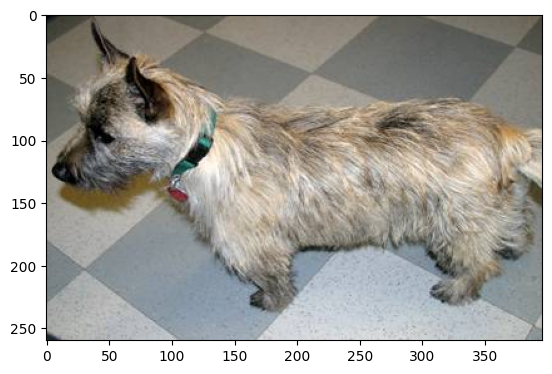

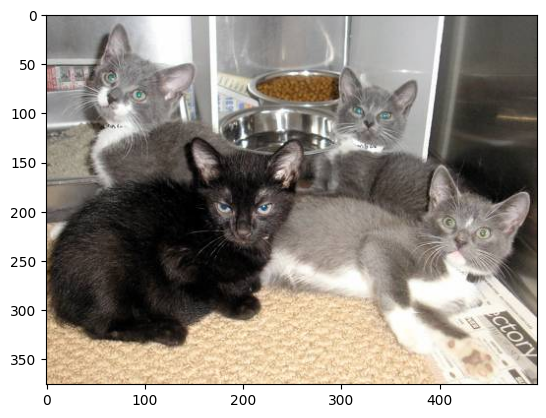

In [5]:
import matplotlib.pyplot as plt
import random


dog_dir = os.listdir(train_dir+'/test'+'/dog')
cat_dir = os.listdir(train_dir+'/test'+'/cat')
dog_sample = random.choice(dog_dir)
cat_sample = random.choice(cat_dir)


dog_img = load_img(os.path.join(train_dir+'/test'+'/dog', dog_sample))
cat_img = load_img(os.path.join(train_dir+'/test'+'/cat', cat_sample))

plt.imshow(dog_img)
plt.show()

plt.imshow(cat_img)
plt.show()

# Baseline CNN Model: VGG-5

In [6]:
# create data generator

# ----------- Target Picture Size ------------ #
target_pic_size = (64, 64)                     #
target_pic_shape = target_pic_size + (3,)      #
# -------------------------------------------- #


train_data = image_dataset_from_directory(train_dir + '/train',
            color_mode='rgb', batch_size=64, image_size=target_pic_size)

val_data = image_dataset_from_directory(train_dir + '/validation',
           color_mode='rgb', batch_size=64, image_size=target_pic_size)

test_data = image_dataset_from_directory(train_dir + '/test',
            color_mode='rgb', batch_size=64, image_size=target_pic_size)


    
model = Sequential()

# Layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=target_pic_shape))
model.add(MaxPooling2D((2, 2)))

# Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

# FC Layers
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.summary()





Found 15000 files belonging to 2 classes.


I0000 00:00:1729880961.765142  117620 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729880961.765226  117620 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729880961.765249  117620 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729880962.127296  117620 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729880962.127460  117620 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-25

Found 3750 files belonging to 2 classes.
Found 6250 files belonging to 2 classes.


/home/rbrin/miniconda3/envs/tf-gpu2/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(train_data, epochs=10, batch_size=64, validation_data=val_data, verbose=1)


Epoch 1/10


I0000 00:00:1729880964.442347  117726 service.cc:146] XLA service 0x7f1a74016570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729880964.442399  117726 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-10-25 14:29:24.482367: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-25 14:29:24.614781: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


  6/235 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.4974 - loss: 35.1198 

I0000 00:00:1729880968.019246  117726 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.5561 - loss: 4.3608 - val_accuracy: 0.6320 - val_loss: 0.6446
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6530 - loss: 0.6174 - val_accuracy: 0.7061 - val_loss: 0.5643
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7038 - loss: 0.5655 - val_accuracy: 0.7200 - val_loss: 0.5448
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7499 - loss: 0.5101 - val_accuracy: 0.7184 - val_loss: 0.5444
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7748 - loss: 0.4720 - val_accuracy: 0.7619 - val_loss: 0.4967
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8082 - loss: 0.4183 - val_accuracy: 0.7651 - val_loss: 0.5138
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8241 - loss: 0.3892 - val_accuracy: 0.7872 - val_loss: 0.4772
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8448 - loss: 0.3502 - val_accuracy: 0.78

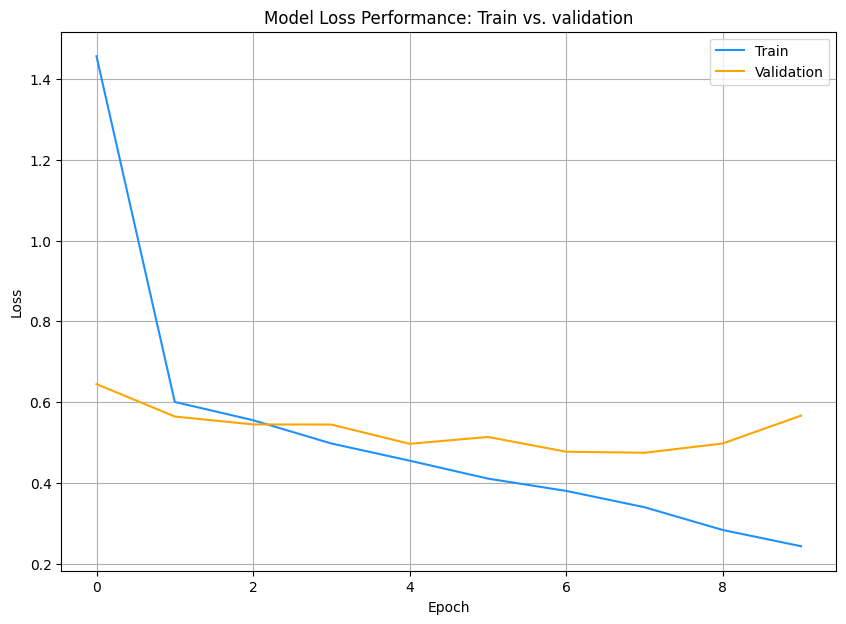

In [8]:
J = history.history['loss']  # Loss data for Training 
J_val = history.history['val_loss']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

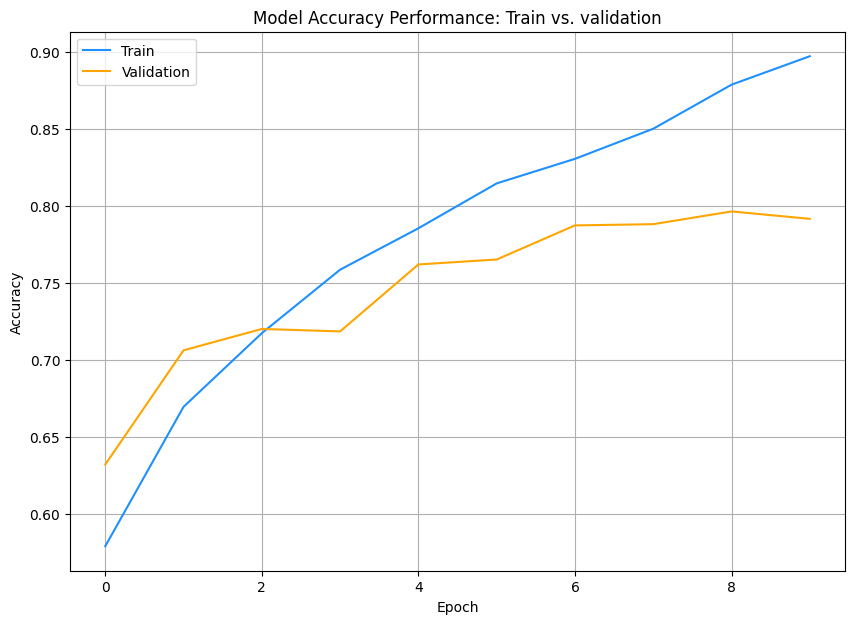

98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7968 - loss: 0.5573
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [9]:
accu = history.history['accuracy']  # Loss data for Training 
accu_val = history.history['val_accuracy']

plt.figure(figsize=(10,7))

plt.title('Model Accuracy Performance: Train vs. validation')
plt.plot(accu, color='DodgerBlue', label='Train')
plt.plot(accu_val, color='orange', label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

loss, accuracy = model.evaluate(test_data, verbose=1)

y_pred = model.predict(test_data)

# <font color=blue>Build CNN Model One</font>

## <font color=green>Define the CNN model</font> 

__Use CONV, POOL and FC layers to construct your CNN model. You can also load pre-trained model, if transfer learning is used. You will train and test the model after this step.__

In [10]:
# ----------- Target Picture Size ------------ #
target_pic_size = (128, 128)                     #
target_pic_shape = target_pic_size + (3,)      #
# -------------------------------------------- #

train_data = image_dataset_from_directory(train_dir + '/train',
            color_mode='rgb', batch_size=64, image_size=target_pic_size)

val_data = image_dataset_from_directory(train_dir + '/validation',
           color_mode='rgb', batch_size=64, image_size=target_pic_size)

test_data = image_dataset_from_directory(train_dir + '/test',
            color_mode='rgb', batch_size=64, image_size=target_pic_size)



cnn1 = Sequential()


# Input layer
cnn1.add(keras.Input(shape=target_pic_shape))

# Layer 1
cnn1.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer='l2'))
cnn1.add(keras.layers.BatchNormalization())
cnn1.add(MaxPooling2D((2, 2)))

# Layer 2
cnn1.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l2'))
cnn1.add(keras.layers.BatchNormalization())
cnn1.add(MaxPooling2D((2, 2)))

# Layer 3
cnn1.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l2'))
cnn1.add(keras.layers.BatchNormalization())
cnn1.add(MaxPooling2D((2, 2)))

# Layer 4
cnn1.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer='l2'))
cnn1.add(keras.layers.BatchNormalization())
cnn1.add(MaxPooling2D((2, 2)))

# Layer 5
cnn1.add(Conv2D(512, (3, 3), activation='relu', kernel_regularizer='l2'))
cnn1.add(keras.layers.BatchNormalization())
cnn1.add(MaxPooling2D((2, 2)))

cnn1.add(Flatten())

# FC Layers
cnn1.add(Dense(128, activation=keras.activations.gelu))
cnn1.add(Dense(128, activation=keras.activations.gelu))
cnn1.add(Dense(1, activation=keras.activations.sigmoid))



Found 15000 files belonging to 2 classes.
Found 3750 files belonging to 2 classes.
Found 6250 files belonging to 2 classes.


### Print the model summary that shows the output shape and # of parameters for each layer.

In [11]:
cnn1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,847,489 (7.05 MB)

 Trainable params: 1,847,489 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

### <font color=red>Question: What are the total number of parameters for the model?</font>

<font color = blue>**Answer:** This model has 1,844,641 parameters and takes up 7.04 MB</font>

## <font color=green>Train the CNN Model</font>

__Note: Display the history when running model.fit( )__

In [146]:
cnn1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = cnn1.fit(train_data, epochs=20, batch_size=64, validation_data=val_data, verbose=1)

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 120ms/step - accuracy: 0.5619 - loss: 5.2685 - val_accuracy: 0.6525 - val_loss: 2.2188
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.6407 - loss: 2.0172 - val_accuracy: 0.6845 - val_loss: 1.4911
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.6809 - loss: 1.4014 - val_accuracy: 0.6984 - val_loss: 1.1407
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.7113 - loss: 1.0766 - val_accuracy: 0.7488 - val_loss: 0.8891
Epoch 5/20
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7432 - loss: 0.8664

### <font color=red>Question: What is the estimated total model training time?</font>

<font color=blue>**Answer:** With the CPU/GPU combination I have it takes about 10 minutes to run</font>

### Compare Loss and Accuracy Performance for train and validation data

#### Plot the loss data, for both train and validation data

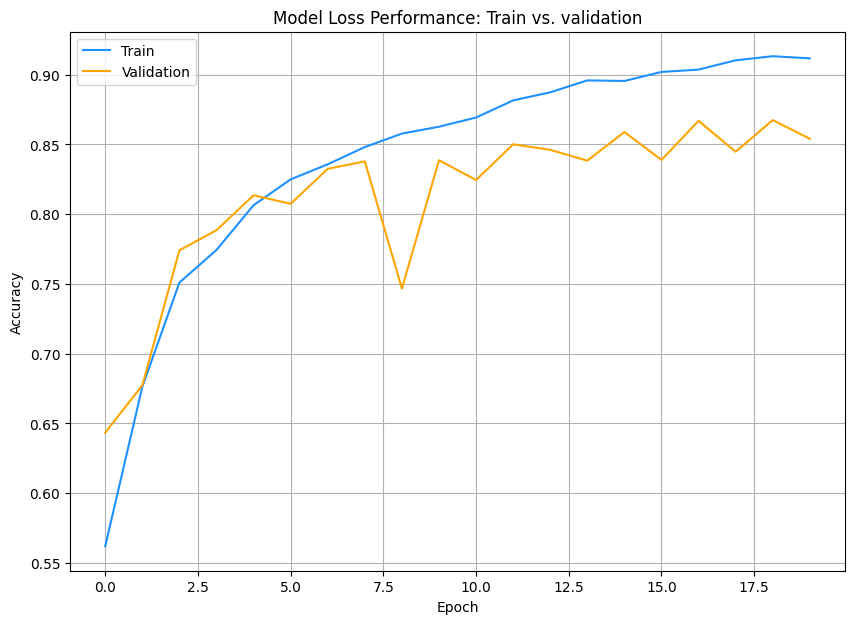

In [113]:
J = history.history['accuracy']  # Loss data for Training 
J_val = history.history['val_accuracy']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

#### Plot the accuracy data, for both train and validation data

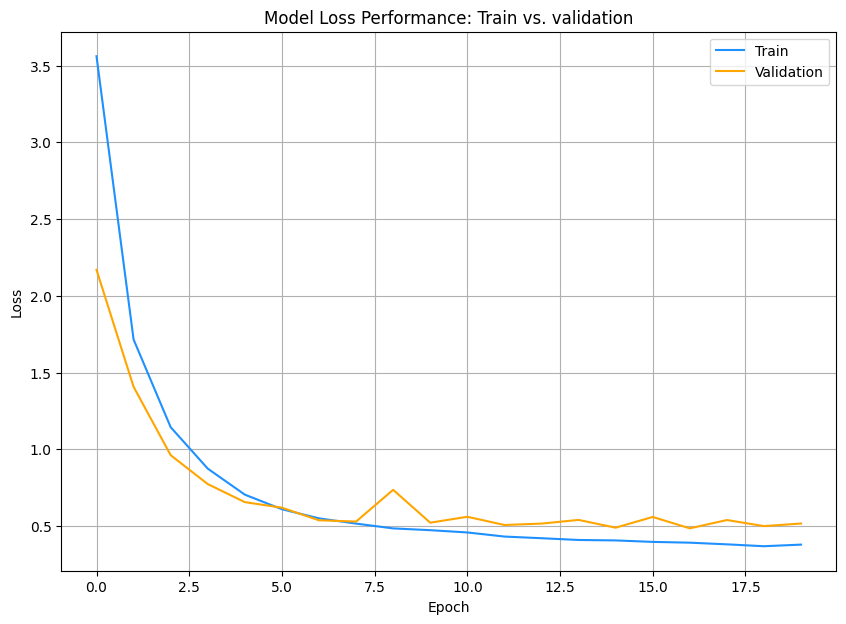

In [114]:
J = history.history['loss']  # Loss data for Training 
J_val = history.history['val_loss']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

## <font color=green>Test the CNN Model</font>
__Note: Display the history when running model.evaluate( )__

### <font color=red>Question: What is the estimated inference (testing) time on test dataset?</font>

<font color = blue>**Answer:** It took 14 seconds to run the inference</font>

### Print the final loss and accuracy of the test data

In [115]:
loss, accuracy = cnn1.evaluate(test_data, verbose=1)

y_pred = cnn1.predict(test_data)

print("Accuracy: ", round(accuracy * 100, 2), "%")
print("Loss: ", round(loss, 2))

98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8522 - loss: 0.5283
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Accuracy:  84.99 %
Loss:  0.54


### Save the CNN model parameters

In [61]:
cnn1.save('./cnn1.keras')

# <font color=blue>Build CNN Model Two</font>

__For your second and subsequent models, follow the same set of instructions provided for Model One__

In [62]:
# ----------- Target Picture Size ------------ #
target_pic_size = (128, 128)                     #
target_pic_shape = target_pic_size + (3,)      #
# -------------------------------------------- #

train_data = image_dataset_from_directory(train_dir + '/train',
            color_mode='rgb', batch_size=64, image_size=target_pic_size)

val_data = image_dataset_from_directory(train_dir + '/validation',
           color_mode='rgb', batch_size=64, image_size=target_pic_size)

test_data = image_dataset_from_directory(train_dir + '/test',
            color_mode='rgb', batch_size=64, image_size=target_pic_size)



cnn2 = Sequential()

cnn2.add(keras.Input(shape=target_pic_shape))

cnn2.add(Conv2D(16, (3,3), activation= 'relu', input_shape = target_pic_shape))
cnn2.add(MaxPooling2D((2,2)))

cnn2.add(Conv2D(32, (3,3), activation= 'relu'))
cnn2.add(MaxPooling2D((2,2)))

cnn2.add(Conv2D(64, (3,3), activation= 'relu'))
cnn2.add(MaxPooling2D((2,2)))

cnn2.add(Conv2D(128, (3,3), activation= 'relu'))
cnn2.add(MaxPooling2D((2,2)))

cnn2.add(Conv2D(256, (3,3), activation= 'relu'))
cnn2.add(MaxPooling2D((2,2)))

cnn2.add(Flatten())

cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dense(1, activation='sigmoid'))

Found 15000 files belonging to 2 classes.
Found 3750 files belonging to 2 classes.
Found 6250 files belonging to 2 classes.


/home/rbrin/miniconda3/envs/tf-gpu2/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [63]:
cnn2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_43 (Conv2D)              │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,937 (2.00 MB)

 Trainable params: 523,937 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
cnn2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = cnn2.fit(train_data, epochs=10, batch_size=64, validation_data=val_data, verbose=1)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5627 - loss: 2.3447 - val_accuracy: 0.7035 - val_loss: 0.5642
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7099 - loss: 0.5551 - val_accuracy: 0.7104 - val_loss: 0.5581
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7572 - loss: 0.4964 - val_accuracy: 0.7760 - val_loss: 0.4823
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7986 - loss: 0.4297 - val_accuracy: 0.8115 - val_loss: 0.4208
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8294 - loss: 0.3779 - val_accuracy: 0.8080 - val_loss: 0.4557
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8591 - loss: 0.3215 - val_accuracy: 0.8040 - val_loss: 0.4284
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8658 - loss: 0.3002 - val_accuracy: 0.8160 - val_loss: 0.4138
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8920 - loss: 0.2430 - val_acc

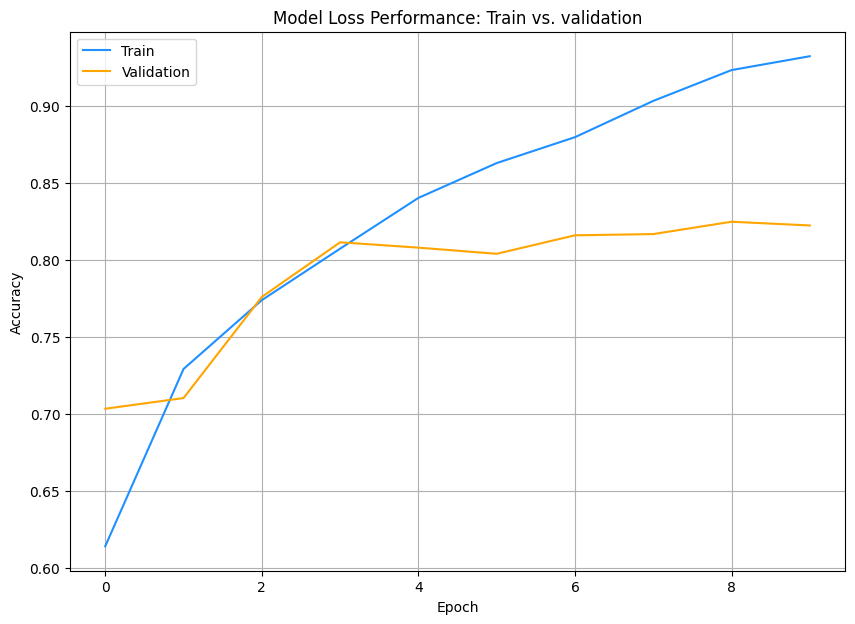

In [65]:
J = history.history['accuracy']  # Loss data for Training 
J_val = history.history['val_accuracy']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

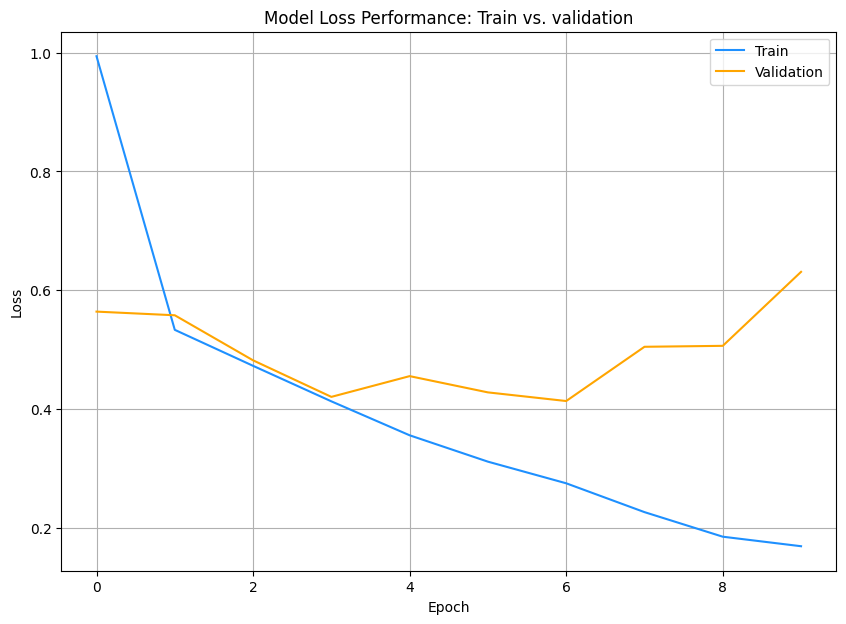

In [66]:
J = history.history['loss']  # Loss data for Training 
J_val = history.history['val_loss']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

In [67]:
loss, accuracy = cnn2.evaluate(test_data, verbose=1)

y_pred = cnn2.predict(test_data)

print("Accuracy: ", round(accuracy * 100, 2), "%")
print("Loss: ", round(loss, 2))

 1/98 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8125 - loss: 0.6947

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8177 - loss: 0.6480
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Accuracy:  81.42 %
Loss:  0.66


In [68]:
cnn2.save('./cnn2.keras')

## <font color=green>Conclusion</font>

### You will fill out information in this table:
| Model              | Accuracy | Number of Parameters | Training Time | Inference Speed |
|-------------------- |----------|-----------------------|--------------- |------------------|
| Baseline VGG-5     |          |                       |                |                  |
| CNN1           |          |                       |                |                  |
| CNN2          |          |                       |                |                  |
| Model Three         |          |                       |                |                  |


__Please add comments on what you tried and observed while working on the assignment.__

## <center><font color=maroon>Remember to turn in both the notebook and the pdf version.</font></center>